# PyTorch Computer Vision

Use Fashion MNIST data to build a PyTorch model having Convolutional Neural Networks !

## Computer Vision libraries in PyTorch

* `torchvision`: base domain for Computer Vision implementation using PyTorch
* `torchvision.datasets`: get different datasets and data loading functions for computer vision here!
* `torchvision.models`: get pre-trained computer vision models that you can fine-tune for your own problems!
* `torchvision.transform`: functions for manipulating your vision data (images)
to be suitable for use with an ML model
* `torch.utils.data.Dataset`: Base Dataset class for PyTorch (make your own dataset)
* `torch.utils.data.DataLoader`: Creates a Python iterable over a dataset

In [1]:
import torch
from torch import nn

# torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchvision.__version__

'0.16.0+cu118'

## Getting a Dataset

> Dataset we'll be using Fashion MNIST dataset, which contains gray-scale (28x28) sized images of 10 different piecing of clothing with labels

In [4]:
# set up training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data
    train=True, # we need the train data
    download=True, # we need to download our data to colab
    transform=torchvision.transforms.ToTensor() # how do we  transform our data
)

# set up testing data
test_data = datasets.FashionMNIST(
    root='data', # Download into this directory
    train=False, # need the testing data
    download=True, # download data to colab
    transform=ToTensor() # transforms our data to ready to use Tensors
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10848454.23it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210076.78it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3892977.58it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22824817.12it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image Shape: torch.Size([1, 28, 28]) 
Label: 9


(-0.5, 27.5, 27.5, -0.5)

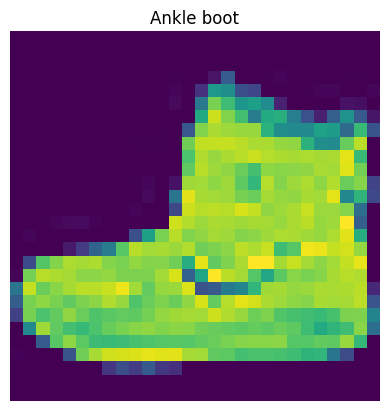

In [8]:
# look at first training example
image, label = train_data[0]
print(f'Image Shape: {image.shape} \nLabel: {label}')

permuted_tensor = torch.permute(image, (1, 2, 0))
plt.imshow(permuted_tensor)
plt.title(class_names[label])
plt.axis('off')

In [9]:
torch.min(image), torch.max(image)

(tensor(0.), tensor(1.))

> So our images are in the shape (1, 28, 28) or [Color_channels, Height, Width], and they are also normalized which was done by our Transforming function `torchvision.transformers.ToTensor()`

### Let's randomly view some random images

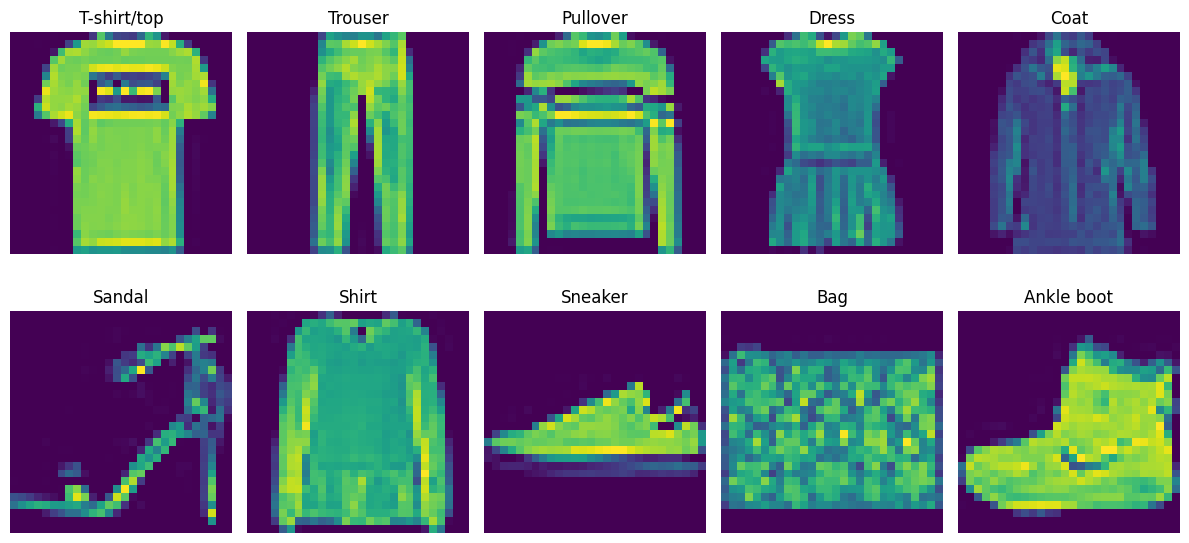

In [10]:
# Initialize variables to store indices of each class
class_indices = {key: [] for key in range(10)}

for idx, (img, label) in enumerate(train_data):
    class_indices[label].append(idx)

# Set up a subplot with 10 images (1 for each class)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

for i in range(10):
    class_img_index = class_indices[i][0]  # Take the first image for each class
    img, label = train_data[class_img_index]

    # Plot the image
    axs[i].imshow(torch.permute(img, [1, 2, 0]))
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Prepare our Data-Loader

* Right now, our data is in the form of PyTorch Datasets.
* DataLoader turns our dataset into a Python iterable

> More specifically, we want to turn our data into mini-batches of size 32, this is because making predictions for 60,000 images all at once for each epoch might be a bit of memory, ram and time-consuming task, therefore we can just turn them into mini-batches of 32, so that our model only looks at 32 images per batch


>It will also give our neural network more chanes to update its trainable parameters, and converge to optimium values faster!


In [11]:
BATCH_SIZE=32

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_data, # pass the train data for batching
    batch_size=BATCH_SIZE, # set batch size to 32
    shuffle=True # Shuffle our data's order of images and labels!
)

test_dataloader = DataLoader(
    dataset=test_data, # pass test data for batching
    batch_size=BATCH_SIZE, # convert data to batches of size 32
    shuffle=False # we do not want to shuffle test images
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78fd4d26f250>,
 <torch.utils.data.dataloader.DataLoader at 0x78fd4d26fe80>)

In [13]:
print(f'Length of our Train Dataloader: {len(train_dataloader)} batches of size {train_dataloader.batch_size}')
print(f'Length of our Test Dataloader: {len(test_dataloader)} batches of size {test_dataloader.batch_size}')

Length of our Train Dataloader: 1875 batches of size 32
Length of our Test Dataloader: 313 batches of size 32


In [14]:
# check out a batch of data
images_batch, labels_batch = next(iter(train_dataloader))
images_batch.shape, labels_batch

(torch.Size([32, 1, 28, 28]),
 tensor([2, 1, 3, 6, 3, 3, 6, 5, 3, 1, 9, 4, 0, 2, 8, 3, 7, 2, 3, 3, 1, 4, 6, 4,
         0, 4, 4, 0, 6, 1, 4, 2]))

(-0.5, 27.5, 27.5, -0.5)

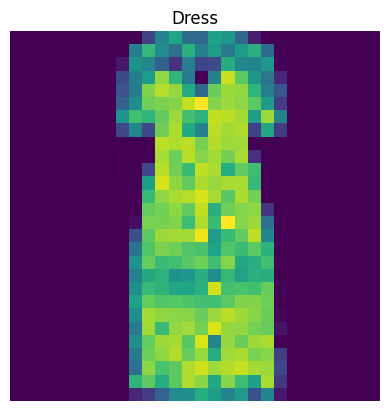

In [15]:
random_idx = torch.randint(0, len(images_batch), (1,))
plt.imshow(images_batch[random_idx].squeeze())
plt.title(f'{class_names[labels_batch[random_idx]]}')
plt.axis("off")

## Model 0: Build a Baseline model

> When starting to build a series of Machine Learning modelling experiments, it's best practices to start with a baseline model!!


A baseline model is a simple model, you will try and imporve upon with subsequent models/experiments.

In other words, **start simply and add complexity when necessary**

In [16]:
# Creater a flatten layer
flatten_model = nn.Flatten()

# Get a single image sample
img = train_data[0][0]
print(f'Image (without flattening): {img.shape}')

# Flatten
output = flatten_model(img)

print(f'Image (after flattening): {output.shape}')

Image (without flattening): torch.Size([1, 28, 28])
Image (after flattening): torch.Size([1, 784])


In [17]:
# set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # create flatten and linear layers
    self.flatten_layer = nn.Flatten()
    self.linear_stack = nn.Sequential(
        nn.Linear(in_features=784, out_features=64),
        nn.Linear(in_features=64, out_features=32),
        nn.Linear(in_features=32, out_features=10),
    )

  def forward(self, X:torch.tensor) -> torch.tensor:
    X = self.flatten_layer(X)
    X = self.linear_stack(X)
    return X


model_0 = FashionMNISTModelV0().to('cpu')
model_0

FashionMNISTModelV0(
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [19]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[ 0.1620, -0.1947, -0.0684, -0.0485,  0.2129, -0.3147,  0.0404, -0.1286,
          0.0443,  0.1405]], grad_fn=<AddmmBackward0>)

### Picking up a loss function and optimizer

In [20]:
# create a loss function for dataset and model
loss_fn = torch.nn.CrossEntropyLoss()

# Initiate an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
def accuracy_fn(y_true, y_preds):
  correct = torch.eq(y_true, y_preds).sum().item()
  acc = correct/len(y_true) * 100
  return acc

## Create a function to time our experiments

Machine Learning is very experimental,

Two of the main things you'll often want to trach are:

1. Model's performance (loss and accuracy values)
2. How fast it runs

Model's Performance and the speed it runs, is usually a trade-off, the bigger the model, more better the performance, but  speed of the model in making predictions decreases!!

In [22]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints differences between start and end time."""
  total_time = end-start
  print(f'Train Time on {device}: {total_time:.3f} secs')
  return total_time

In [23]:
start_time = timer()
## some code here
end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')

Train Time on cpu: 0.000 secs


4.915099998470396e-05

## Make Predictions with our un-trained model

In [24]:
dummy_x = torch.rand([1, 1, 28, 28])
with torch.inference_mode():
  y_logits = model_0(dummy_x)

In [25]:
y_probs = torch.softmax(y_logits, dim=1)
y_probs

tensor([[0.1138, 0.0992, 0.0894, 0.0949, 0.1124, 0.0794, 0.0997, 0.0888, 0.1089,
         0.1135]])

In [26]:
y_preds = torch.argmax(y_probs, dim=1)
y_preds

tensor([0])

## Creating our Training and Testing Loop

> We will train our model on mini-batches of data

Procedures:
1. Loop through epochs
2. Loop through training batches, perform the training steps and calculate the train loss *per batch*
3. Use Gradient descent and Back Propagation
4. Same as point 2, with the testing batches
5. Print out what's happenin`

In [27]:
from tqdm import tqdm

EPOCHS = 3

# start timer
start_time_cpu = timer()

# Loop through our epochs
for epoch in tqdm(range(EPOCHS)):
  print(f'Epoch: {epoch} \n------------')
  # set up train loss values
  train_loss, train_acc = 0, 0

  # set model to train mode
  model_0.train()

  # Iterate through our batches of train data
  for batch, (X, y) in enumerate(train_dataloader):
    # forward propagation
    y_logits = model_0(X)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # calcualte the loss and acc
    loss = loss_fn(y_logits, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_preds)

    # Zero grad - clearing all gradients
    optimizer.zero_grad()
    # Backpropagation
    loss.backward()
    # Gradient Descent
    optimizer.step()

    if batch % 400 == 0:
      print(f'Looked at: {batch*len(X)} / {len(train_dataloader.dataset)} images')

  # calculate the average loss and accuracy over all the training batches
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # Testing time
  model_0.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for test_X, test_y in test_dataloader:
      # Forward propgation
      test_logits = model_0(test_X)
      test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

      # calculate the loss and acc
      test_loss += loss_fn(test_logits, test_y)
      test_acc += accuracy_fn(test_y, test_preds)

    # calculate average test loss and acc
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Print out what's happenin`
  print(f'\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%')


# Calculate the training time on cpu
end_time_cpu = timer()
print_train_time(start=start_time_cpu,
                 end=end_time_cpu,
                 device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
------------
Looked at: 0 / 60000 images
Looked at: 12800 / 60000 images
Looked at: 25600 / 60000 images
Looked at: 38400 / 60000 images
Looked at: 51200 / 60000 images


 33%|███▎      | 1/3 [00:08<00:17,  8.64s/it]


Train loss: 0.60242 | Train acc: 78.39% | Test loss: 0.53376 | Test acc: 81.18%
Epoch: 1 
------------
Looked at: 0 / 60000 images
Looked at: 12800 / 60000 images
Looked at: 25600 / 60000 images
Looked at: 38400 / 60000 images
Looked at: 51200 / 60000 images


 67%|██████▋   | 2/3 [00:17<00:08,  8.89s/it]


Train loss: 0.48446 | Train acc: 83.08% | Test loss: 0.51717 | Test acc: 80.82%
Epoch: 2 
------------
Looked at: 0 / 60000 images
Looked at: 12800 / 60000 images
Looked at: 25600 / 60000 images
Looked at: 38400 / 60000 images
Looked at: 51200 / 60000 images


100%|██████████| 3/3 [00:26<00:00,  8.89s/it]


Train loss: 0.46224 | Train acc: 83.78% | Test loss: 0.48376 | Test acc: 83.00%
Train Time on cpu: 26.684 secs


26.68372960299999

## Make predictions and get model_0 results

In [28]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.1 MB/s eta 0:00:00


In [29]:
from torchmetrics import F1Score

def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device='cpu'):
  """Returns a Dictionary containing model type, loss and accuracy of model
  over the torch.utils.data.DataLoader dataset that was sent in the function

  Args:
      model (torch.nn.Module): A trained PyTorch model capable of making multi-class predictions!
      dataloader (torch.utils.data.DataLoader): Dataset on which model's accuracy and loss can be calculated and returned.
      loss_fn (torch.nn.Module): The loss function of model.
      accuracy_fn: An accuracy function to compare model's predictios with true labels and return accuracy of model.

  Returns:
      (dict): Results of model making predictions on data_loader.
  """

  model.eval()
  with torch.inference_mode():
    # Initialze loss, acc and f1 value + f1_score detector from torchmetrics
    loss, acc, f1 = 0, 0, 0
    torchmetric_f1 = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

    for X, y in tqdm(dataloader):
      X, y = X.to(device), y.to(device)
      # Forward propagation
      y_logits = model(X)
      y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

      # Calculate the loss, acc, f1
      loss += loss_fn(y_logits, y)
      acc += accuracy_fn(y, y_preds)
      f1 += torchmetric_f1(y_preds, y)


    # calculate the average loss
    loss /= len(dataloader)
    acc /= len(dataloader)
    f1 /= len(dataloader)


  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_accuracy": acc,
          "model_f1_Score": f1.item()}

In [30]:
model_0_results = eval_model(model=model_0,
                             dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

100%|██████████| 313/313 [00:01<00:00, 167.71it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.483762264251709,
 'model_accuracy': 82.99720447284345,
 'model_f1_Score': 0.7948022484779358}

## Model 1: Build a better model with non-linearity

In [31]:
# check  if we have device agnostic code
device

'cuda'

In [32]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    # create a linear stack of layers with non-linear activations
    self.linear_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=10),
    )

  def forward(self, X:torch.tensor) -> torch.tensor:
    return self.linear_stack(X)

model_1 = FashionMNISTModelV1().to(device)
model_1, next(model_1.parameters()).device

(FashionMNISTModelV1(
   (linear_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=128, bias=True)
     (2): ReLU()
     (3): Linear(in_features=128, out_features=64, bias=True)
     (4): ReLU()
     (5): Linear(in_features=64, out_features=32, bias=True)
     (6): ReLU()
     (7): Linear(in_features=32, out_features=10, bias=True)
   )
 ),
 device(type='cuda', index=0))

### Set up Loss function and optimizer for out model_1

In [33]:
# loss function
loss_fn = torch.nn.CrossEntropyLoss()
# initialize optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### Functionizing our Training and Test Loops

In [34]:
# Training Loop

def train_model_step(model: torch.nn.Module,
                     dataloader: torch.utils.data.DataLoader,
                     device:str=device,
                     loss_fn=loss_fn,
                     optimizer=optimizer):
  # set model to train mode
  model.train()
  # set up train loss and acc values for accumulating during training
  train_loss, train_acc = 0, 0

  # Loop through batches of data
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    # Forward propagation
    y_logits = model(X)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # calculate  & accumulate loss and acc
    loss = loss_fn(y_logits, y)

    train_loss += loss
    train_acc += accuracy_fn(y, y_preds)

    # Zero grad - clear all gradients
    optimizer.zero_grad()
    # Backpropagation
    loss.backward()
    # Gradient Descent
    optimizer.step()

  # average of all train loss and accuracy values accumulated
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



# Testing Loop

def test_model_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    device:str=device,
                    loss_fn=loss_fn,
                    accuracy_fn=accuracy_fn):
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      # forward pass
      y_logits = model(X)
      y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

      # add & accumulate loss and acc
      test_loss += loss_fn(y_logits, y)
      test_acc += accuracy_fn(y, y_preds)

    # calculate the average loss and acc
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")


### Training our model_1 using training and testing step functions

In [35]:
EPOCHS = 3

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

for epoch in range(EPOCHS):
  print(f'Epoch: {epoch}')

  train_model_step(model=model_1,
                   dataloader=train_dataloader,
                   device=device,
                   loss_fn=loss_fn,
                   optimizer=optimizer)

  test_model_step(model=model_1,
                  dataloader=test_dataloader,
                  device=device,
                  loss_fn=loss_fn,
                  accuracy_fn=accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time = print_train_time(start=train_time_start_on_gpu,
                                    end=train_time_end_on_gpu,
                                    device=device)
print(total_train_time)

Epoch: 0
Train loss: 0.68675 | Train accuracy: 74.20%
Test loss: 0.47500 | Test accuracy: 82.69%
Epoch: 1
Train loss: 0.42649 | Train accuracy: 84.44%
Test loss: 0.40655 | Test accuracy: 84.79%
Epoch: 2
Train loss: 0.37821 | Train accuracy: 86.04%
Test loss: 0.41076 | Test accuracy: 85.22%
Train Time on cuda: 41.635 secs
41.63458938599999


### Evaluating our model

In [36]:
model_1_results = eval_model(model=model_1,
                             dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device='cuda')
model_1_results

100%|██████████| 313/313 [00:02<00:00, 156.03it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.41075703501701355,
 'model_accuracy': 85.22364217252397,
 'model_f1_Score': 0.8222086429595947}

In [37]:
# check baseline model results
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.483762264251709,
 'model_accuracy': 82.99720447284345,
 'model_f1_Score': 0.7948022484779358}

## Model 2: Building a Convolutional Neural Network (CNN)

In [38]:
import torch
from torch import nn

class FashionMNISTModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # create a stack of Conv2d, MaxPooling2D, Flatten, Dense, ReLU layers.
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=32,
                  kernel_size=(3, 3),
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=(3, 3),
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=32*7*7, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=10),
    )

  def forward(self, X:torch.tensor) -> torch.tensor:
    X = self.conv_block1(X)
    # print(f'After Conv Block 1: {X.shape}')
    X = self.conv_block2(X)
    # print(f'After Conv Block 2: {X.shape}')
    X = self.classifier(X)
    return X


In [39]:
model_2 = FashionMNISTModelV2().to(device)
model_2

FashionMNISTModelV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [40]:
torch.argmax(torch.softmax(model_2(dummy_x.to(device)), dim=1), dim=1)

tensor([2], device='cuda:0')

### Setting up our Loss function and optimizer for CNN model

In [41]:
# create loss func
loss_fn = torch.nn.CrossEntropyLoss()

# initiate optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### Training Our CNN model

In [42]:
from timeit import default_timer as timer
model2_train_start_time = timer()

EPOCHS = 3

for epoch in range(EPOCHS):
  print(f'Epoch: {epoch} \n-------')

  train_model_step(
      model=model_2,
      dataloader=train_dataloader,
      device='cuda',
      loss_fn=loss_fn,
      optimizer=optimizer
  )

  test_model_step(
      model=model_2,
      dataloader=test_dataloader,
      device='cuda',
      loss_fn=loss_fn,
      accuracy_fn=accuracy_fn
  )

model2_train_end_time = timer()
model2_train_time = print_train_time(
    start=model2_train_start_time,
    end=model2_train_end_time,
    device='cuda'
)

Epoch: 0 
-------
Train loss: 0.80826 | Train accuracy: 69.30%
Test loss: 0.40031 | Test accuracy: 85.16%
Epoch: 1 
-------
Train loss: 0.33956 | Train accuracy: 87.30%
Test loss: 0.32216 | Test accuracy: 88.37%
Epoch: 2 
-------
Train loss: 0.27438 | Train accuracy: 89.86%
Test loss: 0.27954 | Test accuracy: 90.11%
Train Time on cuda: 37.587 secs


In [43]:
# getting model results
model_2_results = eval_model(
    model=model_2,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device='cuda'
)
model_2_results

100%|██████████| 313/313 [00:01<00:00, 199.29it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2795449197292328,
 'model_accuracy': 90.10583067092652,
 'model_f1_Score': 0.8782147765159607}

## Compare model results and training time

Create a `pd.DataFrame()` out of our model result dicitionaries

In [44]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_accuracy,model_f1_Score
0,FashionMNISTModelV0,0.483762,82.997204,0.794802
1,FashionMNISTModelV1,0.410757,85.223642,0.822209
2,FashionMNISTModelV2,0.279545,90.105831,0.878215


In [45]:
# Add Training time to results comparison
compare_results['training_time'] = [32.00255365200002,
                                    total_train_time,
                                    model2_train_time]

In [46]:
compare_results

,model_name,model_loss,model_accuracy,model_f1_Score,training_time
0,FashionMNISTModelV0,0.483762,82.997204,0.794802,32.002554
1,FashionMNISTModelV1,0.410757,85.223642,0.822209,41.634589
2,FashionMNISTModelV2,0.279545,90.105831,0.878215,37.587208


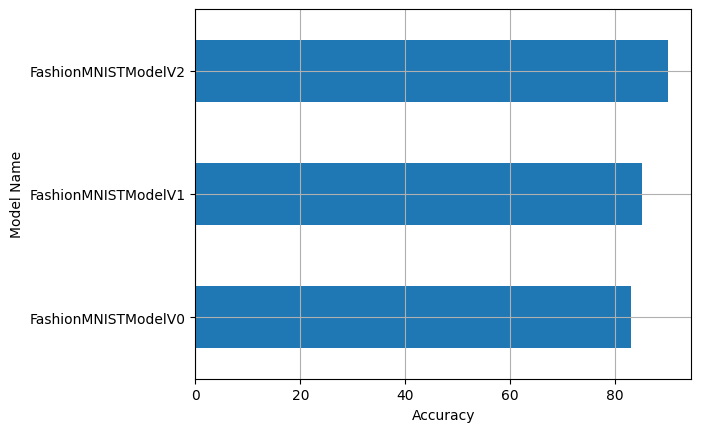

In [47]:
## Visualize model results
compare_results.set_index("model_name")['model_accuracy'].plot(kind='barh')
plt.xlabel('Accuracy')
plt.ylabel('Model Name')
plt.grid()
plt.show()

## Make and evaluate random predictions with best model

In [48]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device:str=device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # sample  = image
      sample = torch.unsqueeze(torch.tensor(sample), dim=0).to(device)
      # Forward pass
      y_logits = model(sample)

      # get probabilities
      y_probs = torch.softmax(y_logits, dim=1).to(device)

      # Append probabilties to pred_probs
      pred_probs.append(y_probs)

  return torch.stack(pred_probs)

In [49]:
img, label = list(test_data)[0]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [50]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape, test_labels[0]

(torch.Size([1, 28, 28]), 5)

(-0.5, 27.5, 27.5, -0.5)

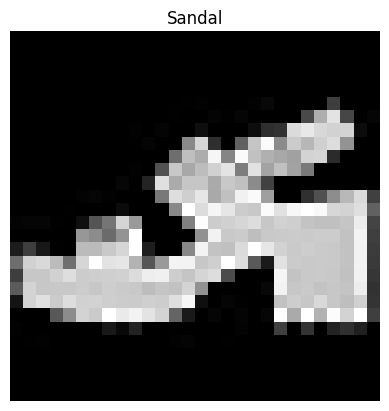

In [51]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])
plt.axis('off')

In [52]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

pred_probs[0], pred_probs.shape

<ipython-input-48-9161b58856e3>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.unsqueeze(torch.tensor(sample), dim=0).to(device)


(tensor([[2.5815e-08, 6.7200e-10, 3.8644e-10, 6.0391e-10, 9.0709e-10, 9.9993e-01,
          5.2999e-07, 2.8603e-07, 1.5371e-08, 6.6952e-05]], device='cuda:0'),
 torch.Size([9, 1, 10]))

In [66]:
test_predictions = torch.argmax(pred_probs, dim=2).squeeze()
test_predictions

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1], device='cuda:0')

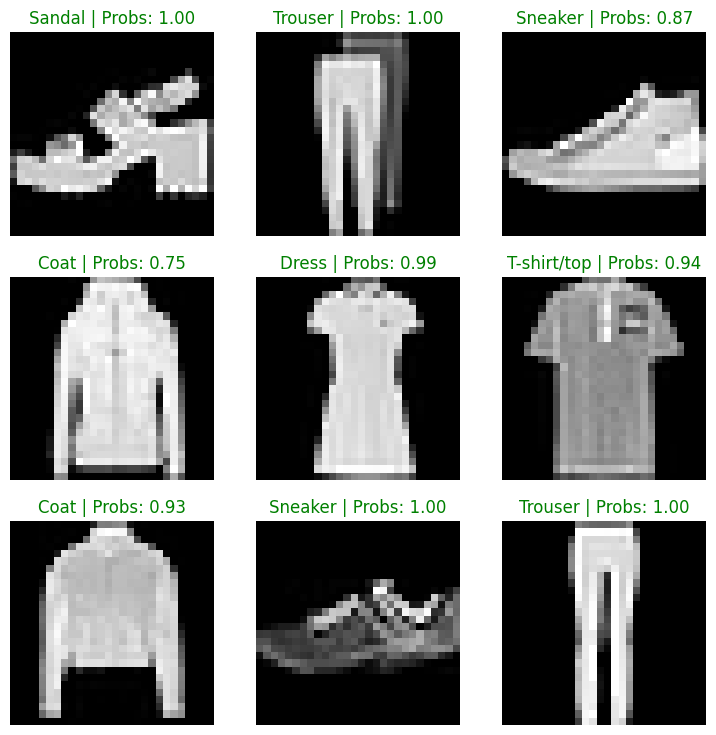

In [69]:
plt.figure(figsize=(9, 9))

nrows=3
ncols=3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap='gray')

  truth_label = test_labels[i]
  probs = torch.max(pred_probs[i]).item()
  class_name = class_names[test_predictions[i]]

  title_text = f'{class_name} | Probs: {probs:.2f}'
  if test_predictions[i] == test_labels[i]:
    plt.title(title_text, c='green')
  else:
    plt.title(title_text, c='red')
  plt.axis('off')

## Making a confusion matrix for further prediction evaluation

In [54]:
# Making predictions with our Model 2 (CNN)
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logits = model_2(X)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    y_preds.extend(list(y_pred.cpu()))

y_preds = torch.tensor(y_preds)
y_preds[:5], y_preds.shape

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 212.42it/s]


(tensor([9, 2, 1, 1, 6]), torch.Size([10000]))

In [55]:
from torchmetrics import ConfusionMatrix
confmat = ConfusionMatrix(task='MULTICLASS', num_classes=10)
matrix = confmat(y_preds, test_data.targets)
matrix

tensor([[915,   3,  12,  24,   4,   1,  38,   0,   3,   0],
        [  1, 986,   0,  10,   2,   0,   1,   0,   0,   0],
        [ 19,   2, 851,  12,  68,   0,  48,   0,   0,   0],
        [ 19,   3,   8, 925,  29,   0,  15,   0,   1,   0],
        [  0,   2,  49,  27, 823,   0,  99,   0,   0,   0],
        [  0,   0,   0,   0,   0, 976,   0,  12,   0,  12],
        [218,   3,  70,  33,  46,   0, 627,   0,   3,   0],
        [  0,   0,   0,   0,   0,   8,   0, 972,   1,  19],
        [  6,   2,   4,   3,   5,   1,   4,   1, 974,   0],
        [  1,   0,   0,   0,   0,   5,   0,  32,   0, 962]])

In [56]:
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


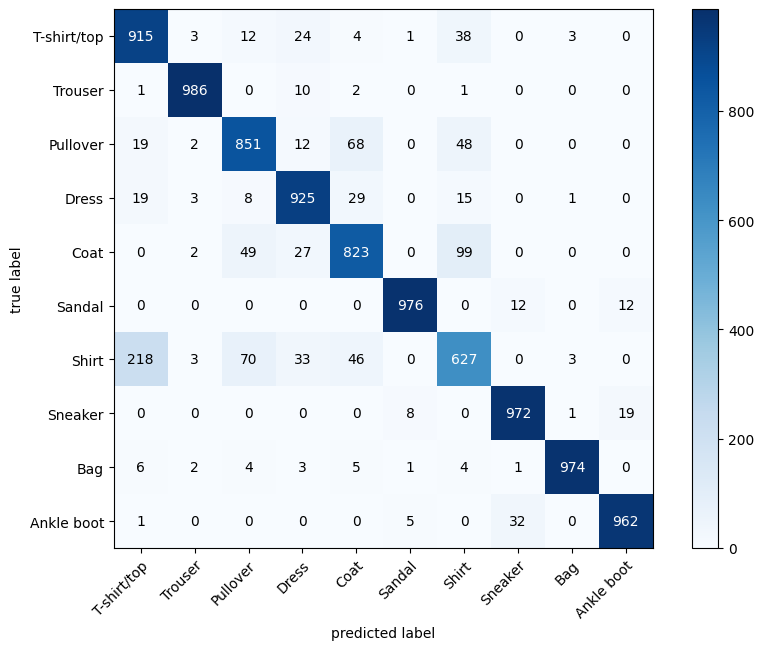

In [57]:
# Plotting our confusion matrix
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=matrix.numpy(),
                                colorbar=True,
                                class_names=class_names,
                                figsize=(10, 7))
plt.show()

## Saving and Re-loading our models

In [58]:
# Saving our model_2's (CNN) state_dict
torch.save(model_2.state_dict(), 'FashionMNIST_cnn_model.pt')

In [59]:
loaded_cnn_model = FashionMNISTModelV2().to(device)
loaded_cnn_model.load_state_dict(torch.load('FashionMNIST_cnn_model.pt'))

<All keys matched successfully>

In [60]:
loaded_cnn_model

FashionMNISTModelV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [61]:
# Making predictions with our Model 2 (CNN)
loaded_y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logits = loaded_cnn_model(X)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    loaded_y_preds.extend(list(y_pred.cpu()))

loaded_y_preds = torch.tensor(loaded_y_preds)
loaded_y_preds[:5], y_preds.shape

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 225.23it/s]


(tensor([9, 2, 1, 1, 6]), torch.Size([10000]))

In [62]:
loaded_y_preds == y_preds

tensor([True, True, True,  ..., True, True, True])